# Titanic Dataset EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
titanic_train = pd.read_csv("../data/train.csv")
titanic_test = pd.read_csv("../data/test.csv")

In [3]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
titanic_train[titanic_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


## Helper Functions

In [171]:
def calc_survival_rate(df):
    survived = sum(df['Survived'] == 1)
    total = len(df)
    return round(survived/total*100,2)

def calc_survival_count(df):
    survived = sum(df['Survived'] == 1)
    return survived

def calc_age_cat(passenger):
    if passenger['Age'] <= 14:
        return "Child"
    elif passenger['Age'] <= 24:
        return "Youth"
    elif passenger['Age'] <= 64:
        return "Adult"
    else:
        return "Senior"
    
def calc_passenger_profile_avg_age(df,passenger):
    passenger_pclass = passenger['Pclass']
    passenger_sex = passenger['Sex']
    passenger_sibsp = passenger['SibSp']
    passenger_parch = passenger['Parch']
    passenger_embarked = passenger['Embarked']
    
    profile = ['Pclass','Sex','SibSp','Parch','Embarked']
    passenger_profile = {'Pclass': passenger_pclass,'Sex': passenger_sex,'SibSp':passenger_sibsp,'Parch':passenger_parch,'Embarked':passenger_embarked}
    
    profile_avg_age = df.groupby(profile,as_index = False)['Age'].mean()

    i = len(passenger_profile)
    for n in range(i):
        profile_col = profile[n]
        profile_avg_age = profile_avg_age[profile_avg_age[profile_col]==passenger_profile[profile_col]]
        
    while pd.isna(profile_avg_age['Age'].values[0]):
        i -= 1
        profile_avg_age = df.groupby(profile[:i],as_index = False)['Age'].mean()
        
        for n in range(i):
            profile_col = profile[n]
            profile_avg_age = profile_avg_age[profile_avg_age[profile_col]==passenger_profile[profile_col]]
            
    return profile_avg_age['Age'].values[0]
    

## Overall Survival Rate

In [7]:
calc_survival_rate(titanic_train)

38.38

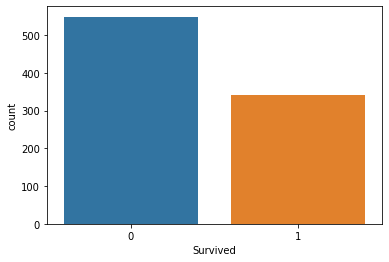

In [8]:
ax = sns.countplot(x=titanic_train['Survived'])

## Survival Rate by Sex

In [9]:
titanic_train_male = titanic_train[titanic_train['Sex']=='male']
titanic_train_female = titanic_train[titanic_train['Sex']=='female']

In [186]:
male_survival_rate = calc_survival_rate(titanic_train_male)
male_survival_count = calc_survival_count(titanic_train_male)

female_survival_rate = calc_survival_rate(titanic_train_female)
female_survival_count = calc_survival_count(titanic_train_female)

print("Male Survival Rate: {}, Male Survival Count: {}".format(male_survival_rate,male_survival_count))
print("Female Survival Rate: {}, Female Survival Count: {}".format(female_survival_rate,female_survival_count))

Male Survival Rate: 18.89, Male Survival Count: 109
Female Survival Rate: 74.2, Female Survival Count: 233


In [188]:
print(len(titanic_train_male))
print(len(titanic_train_female))

577
314


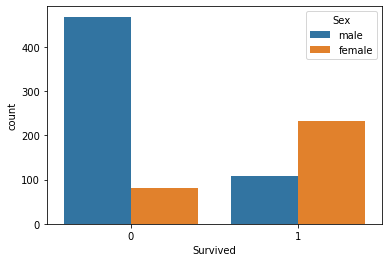

In [11]:
ax = sns.countplot(x=titanic_train['Survived'],hue=titanic_train['Sex'])

## Survival Rate by Age

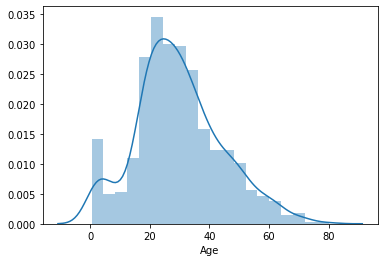

In [12]:
sns.distplot(a=titanic_train['Age'])

In [168]:
titanic_train['Age_fill'] = titanic_train.apply(lambda x: calc_passenger_profile_avg_age(titanic_train,x) if pd.isna(x['Age']) else x['Age'],axis=1)

In [170]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Age_fill     891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [173]:
titanic_train['AgeCategory'] = titanic_train.apply(lambda x: calc_age_cat(x), axis=1)

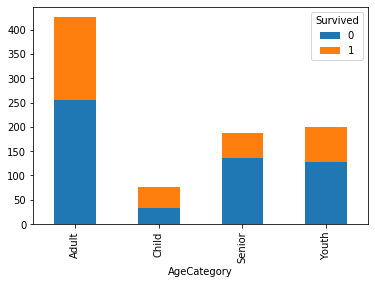

In [185]:
age_cat_plot = titanic_train.groupby(['AgeCategory', 'Survived']).size().reset_index().pivot(columns='Survived', index='AgeCategory', values=0)
age_cat_plot.plot(kind='bar', stacked=True)